# Analyzing EL at 99% percentile with Monte Carlo Simulations

## Description of the problem we like to solve

We have 3 portfolios of assets.
The average PD can change overtime.
Let's calculate via a Monte Carlo simulation how the EL will change overtime.
And let's analyse what the EL will be at 99 percentile.

Starting situation:

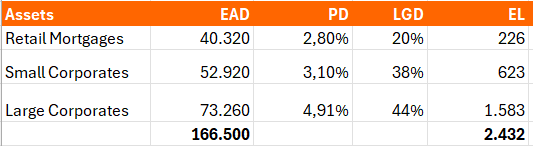

## Function for calculating the EL

We need to recalculate the EL of al 3 portfolios, based on 3 generated PD's.
We keep the EAD and LGD the same for the 3 portfolios.

In [83]:
def el_calculation(pd_1=0.028, pd_2=0.031, pd_3=0.0491):
    el = (pd_1 * 40320 * 0.2) + (pd_2 * 52920 * 0.38) + (pd_3 * 73260 * 0.44)
    return el

el_calculation() # test function with default parameters

2431.89864

It works for the initial inputs, also trying with other inputs.

In [86]:
el_calculation(0.035, 0.032, 0.05)

2537.4672

So it seems our model function is working correctly.

## Run the model with Monte Carlo Simulations

Now we have to generate 3 PD's based on standard deviation en run the model for 10000 times.
We will create a function for this.
Via the random library we can generate random pd's based on standard deviation.

In [91]:
import random

def ports_el_simulations(pd_1_mean=0.028, pd_2_mean=0.031, pd_3_mean=0.0491, std=0.05, n_iter=10000):
    outputs = []
    for i in range(n_iter):
        pd_1 = random.normalvariate(pd_1_mean, std)
        pd_2 = random.normalvariate(pd_2_mean, std)
        pd_3 = random.normalvariate(pd_3_mean, std)
        el = el_calculation(pd_1, pd_2, pd_3)
        outputs.append(el)
    return outputs

results = ports_el_simulations()
print(f'There are {len(results)} results. First five:')
results[:5]

There are 10000 results. First five:


[-609.8330239037956,
 5811.876030061954,
 976.3906084605115,
 4542.299989711537,
 -595.0625764840073]

## Analyze the Outputs

#### Probabilities table

We would like to see two other kinds of outputs. One is a table of probabilities, along with the result which is achived at that probability in the distribution. E.g. at 20%, only 20% of cases are lower than the given value. At 75%, 75% of cases are lower than the given value.

First we'll get the percentiles we want to explore in the table.

In [97]:
percentiles = [i/100 for i in range(1, 100)]
percentiles

[0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.57,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.69,
 0.7,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98,
 0.99]

Now we can use the `.quantile` method from `pandas` to get this table easily. 

In [100]:
import pandas as pd

df = pd.DataFrame()
df['Portfolio ELs'] = results
df['Portfolio ELs'].quantile(percentiles)

0.01   -2113.382951
0.02   -1596.338423
0.03   -1224.939750
0.04   -1011.921196
0.05    -818.988722
           ...     
0.95    5634.087342
0.96    5842.279970
0.97    6089.334387
0.98    6393.675730
0.99    6856.906881
Name: Portfolio ELs, Length: 99, dtype: float64

#### Probability of achieving objective

The other kind of output is the probability that we will achieve our objective. We want to find the probability we will have with an EL of 2,432. We expect to have this around 50% of all cases. Lets's find out if this is a correct estimation.
There's not a direct `pandas` function for this. What we want to calculate is basically the percentage of observations that have a value equal to or higher than our desired objective (2,432). We convert the boolean answers to integers, via this function:

In [104]:
( df['Portfolio ELs'] >= 2432 ).astype(int)

0       0
1       1
2       0
3       1
4       0
       ..
9995    1
9996    1
9997    0
9998    1
9999    0
Name: Portfolio ELs, Length: 10000, dtype: int32

Now we have 1 when it is greater, and 0 otherwise. So the average of this will produce the probability.

### Putting the Visualization and Probabilities Together

We just want to wrap this up into a few functions, to make it easier to run for the next step.

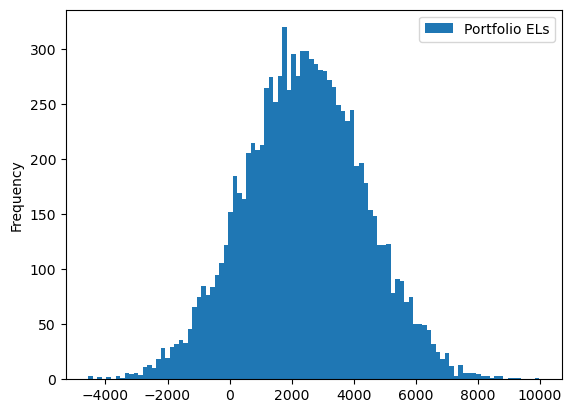

Probability Table
0.01    $-2113.38
0.02    $-1596.34
0.03    $-1224.94
0.04    $-1011.92
0.05     $-818.99
          ...    
0.95     $5634.09
0.96     $5842.28
0.97     $6089.33
0.98     $6393.68
0.99     $6856.91
Name: Portfolio ELs, Length: 99, dtype: object

Probability of EL $2,432 : 49.4%



In [109]:
import matplotlib.pyplot as plt

def probability_table(df):
    percentiles = [i/100 for i in range(1, 100)]
    return df['Portfolio ELs'].quantile(percentiles)

def probability_of_objective(df, desired_el):
    return ( df['Portfolio ELs'] >= desired_el ).astype(int).mean()

def model_outputs(results, desired_el):
    df = pd.DataFrame()
    df['Portfolio ELs'] = results
    df.plot.hist(bins=100)
    plt.show()  # makes plot show right now, which we will need when running this multiple times
    prob_table = probability_table(df)
    prob_objective = probability_of_objective(df, desired_el=desired_el)
    return prob_table, prob_objective

def display_model_summary(results, desired_el=2432):
    prob_table, prob_objective = model_outputs(results, desired_el=desired_el)
    print('Probability Table')
    print(prob_table.apply(lambda x: f'${x:.2f}'))  # a way of formatting a pandas series
    print('')
    print(f'Probability of EL ${desired_el:,.0f} : {prob_objective:.1%}')
    print('')
    
display_model_summary(results)

## Conclusions

With this EL calculation for our 3 portfolio's we are with an EL of 6969.82 save at 99% of the cases.
The probability of EL having 2,432 is indeed around 50%.